# Phishing Link Identifier

Amelia Farrell

3/7/25


In [ ]:
# Connecting to google drive
from google.colab import drive
drive.mount('/content/drive')

# Change to the google drive directory
%cd /content/drive/MyDrive/Colab\ Notebooks/DSC680

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks/DSC680


In [14]:
# importing first libraries needed
import numpy as np
import pandas as pd
import re
from urllib.parse import urlparse
import math
from collections import Counter
from urllib.parse import urlparse
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

## 1. Data Discovery and Creation

Veiwing the dataset

In [ ]:
# loading dataset as a data frame
df = pd.read_csv('url_data (1).csv')
df = pd.DataFrame(df)
df.head(5)

,url,type
0,https://www.google.com,legitimate
1,https://www.youtube.com,legitimate
2,https://www.facebook.com,legitimate
3,https://www.baidu.com,legitimate
4,https://www.wikipedia.org,legitimate


In [ ]:
# count number of rows/observations
num_rows = len(df)
print(num_rows)

450176


In [ ]:
# Convert the 'url' column to string
df['url'] = df['url'].astype(str)

Parsing URLs into meaningful attributes by first creating the functions to do so.

In [ ]:
import re
import math
from collections import Counter
from urllib.parse import urlparse

# --- Levenshtein Distance Function ---
def levenshtein_distance(s1, s2):
    if len(s1) < len(s2):
        return levenshtein_distance(s2, s1)
    if len(s2) == 0:
        return len(s1)
    previous_row = range(len(s2) + 1)
    for i, c1 in enumerate(s1):
        current_row = [i + 1]
        for j, c2 in enumerate(s2):
            insertions = previous_row[j + 1] + 1
            deletions = current_row[j] + 1
            substitutions = previous_row[j] + (c1 != c2)
            current_row.append(min(insertions, deletions, substitutions))
        previous_row = current_row
    return previous_row[-1]

# --- URL Parsing and Feature Extraction Functions ---

# Safe wrapper to parse URLs and handle malformed URLs
def safe_parse_url(url):
    try:
        parsed_url = urlparse(url)
        return parsed_url
    except Exception as e:
        return urlparse('http://invalid.url')  # Return a default malformed URL object

# For Levenshtein distance
def min_levenshtein_distance(url):
    try:
        parsed_url = safe_parse_url(url)
        domain = parsed_url.netloc
        domain = domain.replace('www.', '')  # Remove 'www.' if present
        if not domain:
            return float('inf')
        known_domains = ['google.com', 'youtube.com', 'facebook.com', 'baidu.com']  # Simulated list
        distances = [levenshtein_distance(domain, known) for known in known_domains]
        return min(distances)
    except Exception:
        return float('inf')

def has_https(url):
    return True if url.startswith("https") else False

def get_tld(url):
    try:
        parsed_url = safe_parse_url(url)
        domain = parsed_url.netloc
        if not domain or domain == '.' or '.' not in domain:
            return ''  # Return empty string for invalid URLs
        tld = domain.split('.')[-1] if '.' in domain else ''
        return tld
    except Exception:
        return ''  # Return empty string if there's an error

def count_dots(url):
    return url.count('.')

def count_slashes(url):
    return url.count('/')

def count_numbers(url):
    return len(re.findall(r'\d', url))

def count_alpha_chars(url):
    return len(re.findall(r'[a-zA-Z]', url))

def total_length(url):
    return len(url)

def longest_repeated_sequence(url):
    if not url:
        return 0
    max_count = 1
    current_count = 1
    current_char = url[0]
    for i in range(1, len(url)):
        if url[i] == current_char:
            current_count += 1
            max_count = max(max_count, current_count)
        else:
            current_char = url[i]
            current_count = 1
    return max_count

def has_subdomains(url):
    parsed_url = safe_parse_url(url)
    domain = parsed_url.netloc
    parts = domain.split('.')
    return len(parts) > 2

def count_subdomains(url):
    parsed_url = safe_parse_url(url)
    domain = parsed_url.netloc
    parts = domain.split('.')
    return max(0, len(parts) - 2)

suspicious_keywords = ['login', 'secure', 'verify', 'account', 'update', 'signin', 'password']
def has_suspicious_keywords(url):
    url_lower = url.lower()
    return any(keyword in url_lower for keyword in suspicious_keywords)

def count_suspicious_keywords(url):
    url_lower = url.lower()
    return sum(1 for keyword in suspicious_keywords if keyword in url_lower)

def has_ip_address(url):
    parsed_url = safe_parse_url(url)
    domain = parsed_url.netloc
    ip_pattern = r'^\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}$'
    return bool(re.match(ip_pattern, domain))

special_chars = ['@', '-', '%', '=', '&', '?']
def has_special_chars(url):
    return any(char in url for char in special_chars)

def count_special_chars(url):
    return sum(url.count(char) for char in special_chars)

def domain_length(url):
    parsed_url = safe_parse_url(url)
    domain = parsed_url.netloc
    return len(domain)

def path_length(url):
    parsed_url = safe_parse_url(url)
    path = parsed_url.path
    return len(path)

def calculate_entropy(url):
    if not url:
        return 0
    length = len(url)
    char_count = Counter(url)
    entropy = -sum((count / length) * math.log2(count / length) for count in char_count.values())
    return entropy

shortening_services = ['bit.ly', 'tinyurl.com', 'goo.gl', 't.co']
def is_shortened_url(url):
    parsed_url = safe_parse_url(url)
    domain = parsed_url.netloc
    return any(service in domain for service in shortening_services)

def digit_to_letter_ratio(url):
    num_digits = len(re.findall(r'\d', url))
    num_letters = len(re.findall(r'[a-zA-Z]', url))
    return num_digits / num_letters if num_letters > 0 else 0


# Presence of Port Numbers (with additional validation)
def has_port_number(url):
    try:
        parsed_url = safe_parse_url(url)
        return parsed_url.port is not None  # Check if port is present
    except ValueError:
        return False  # Return False if there's an error parsing the port

# Presence of Punycode
def has_punycode(url):
    parsed_url = safe_parse_url(url)
    domain = parsed_url.netloc
    return domain.startswith('xn--')

# Number of Query Parameters
def count_query_params(url):
    parsed_url = safe_parse_url(url)
    query = parsed_url.query
    if not query:
        return 0
    return len(query.split('&'))

# Presence of Hexadecimal/Encoded Characters
def has_encoded_chars(url):
    return bool(re.search(r'%[0-9A-Fa-f]{2}', url))

# Levenshtein Distance to Known Legitimate Domains
known_domains = ['google.com', 'youtube.com', 'facebook.com', 'baidu.com']  # Simulated list
def min_levenshtein_distance(url):
    parsed_url = safe_parse_url(url)
    domain = parsed_url.netloc
    domain = domain.replace('www.', '')  # Remove 'www.' if present
    if not domain:
        return float('inf')
    distances = [levenshtein_distance(domain, known) for known in known_domains]
    return min(distances)

# Presence of Mixed Case in Domain
def has_mixed_case(url):
    parsed_url = safe_parse_url(url)
    domain = parsed_url.netloc
    return any(c.isupper() for c in domain) and any(c.islower() for c in domain)

# Ratio of Vowels to Consonants in Domain
def vowel_to_consonant_ratio(url):
    parsed_url = safe_parse_url(url)
    domain = parsed_url.netloc
    domain = domain.lower()
    vowels = set('aeiou')
    num_vowels = sum(1 for char in domain if char in vowels)
    num_consonants = sum(1 for char in domain if char.isalpha() and char not in vowels)
    return num_vowels / num_consonants if num_consonants > 0 else 0

Applying the above functions to list of ULRs. This will give us the 48 attributes needed to train a ML model to predict phishing (true/false)

In [ ]:
# --- Apply All Features to the DataFrame ---
df['https'] = df['url'].apply(has_https)
df['tld'] = df['url'].apply(get_tld)
df['num_dots'] = df['url'].apply(count_dots)
df['num_slashes'] = df['url'].apply(count_slashes)
df['num_numbers'] = df['url'].apply(count_numbers)
df['num_alpha_chars'] = df['url'].apply(count_alpha_chars)
df['total_length'] = df['url'].apply(total_length)
df['repeated_chars'] = df['url'].apply(longest_repeated_sequence)
df['has_subdomains'] = df['url'].apply(has_subdomains)
df['num_subdomains'] = df['url'].apply(count_subdomains)
df['has_suspicious_keywords'] = df['url'].apply(has_suspicious_keywords)
df['num_suspicious_keywords'] = df['url'].apply(count_suspicious_keywords)
df['has_ip_address'] = df['url'].apply(has_ip_address)
df['has_special_chars'] = df['url'].apply(has_special_chars)
df['num_special_chars'] = df['url'].apply(count_special_chars)
df['domain_length'] = df['url'].apply(domain_length)
df['path_length'] = df['url'].apply(path_length)
df['entropy'] = df['url'].apply(calculate_entropy)
df['is_shortened_url'] = df['url'].apply(is_shortened_url)
df['digit_to_letter_ratio'] = df['url'].apply(digit_to_letter_ratio)
df['has_port_number'] = df['url'].apply(has_port_number)
df['has_punycode'] = df['url'].apply(has_punycode)
df['num_query_params'] = df['url'].apply(count_query_params)
df['has_encoded_chars'] = df['url'].apply(has_encoded_chars)
df['min_levenshtein_distance'] = df['url'].apply(min_levenshtein_distance)
df['has_mixed_case'] = df['url'].apply(has_mixed_case)
df['vowel_to_consonant_ratio'] = df['url'].apply(vowel_to_consonant_ratio)

In [ ]:
# Save the result to a CSV file
df.to_csv('parsed_urls.csv', index=False)

Viewing new data frame with parsed URLs / features

In [ ]:
# loading dataset as a data frame
df = pd.read_csv('parsed_urls.csv.csv')
df = pd.DataFrame(df)
df.head(5)

In [ ]:
# Display the resulting DataFrame
df.head(5)

,url,type,https,tld,num_dots,num_slashes,num_numbers,num_alpha_chars,total_length,repeated_chars,...,entropy,is_shortened_url,digit_to_letter_ratio,has_port_number,has_punycode,num_query_params,has_encoded_chars,min_levenshtein_distance,has_mixed_case,vowel_to_consonant_ratio
0,https://www.google.com,legitimate,True,com,2,2,0,17,22,3,...,3.663533,False,0.0,False,False,0,False,0.0,False,0.500000
1,https://www.youtube.com,legitimate,True,com,2,2,0,18,23,3,...,3.762267,False,0.0,False,False,0,False,0.0,False,0.625000
2,https://www.facebook.com,legitimate,True,com,2,2,0,19,24,3,...,3.855389,False,0.0,False,False,0,False,0.0,False,0.555556
3,https://www.baidu.com,legitimate,True,com,2,2,0,16,21,3,...,3.880180,False,0.0,False,False,0,False,0.0,False,0.571429
4,https://www.wikipedia.org,legitimate,True,org,2,2,0,20,25,3,...,3.813661,False,0.0,False,False,0,False,10.0,False,0.666667


In [ ]:
# count number of rows/observations to ensure none where lost during parsing
num_rows = len(df)
print(num_rows)

450176


All other columns other than 'tld'(top-level domain) have converted correctly. Now we want to transform 'tld' into one column for each equaling true or false (1/0). However, this is likely quite a number of tlds which will create too many columns (for our machine to handle). We will count the number of tdls to see if this transformation will cause problems.

In [ ]:
# Count unique TLDs in the DataFrame
unique_tlds_count = df['tld'].nunique()
print(unique_tlds_count)

1476


In [ ]:
# Count occurrences of each TLD and get the top 20
top_20_tlds = df['tld'].value_counts().head(20)

# Display the result
print(top_20_tlds)

tld
com     316168
org      38324
net      16540
ca       10080
edu       6967
uk        5988
ru        3732
br        3666
au        3250
info      2953
gov       2604
in        1698
pl        1626
us        1565
it        1366
de        1339
biz       1192
ro         986
za         939
eu         837
Name: count, dtype: int64


In [ ]:
# Get the top 20 most common TLDs
top_20_tlds = df['tld'].value_counts().head(20).index

# Replace TLDs not in the top 20 with "other"
df['tld'] = df['tld'].apply(lambda x: x if x in top_20_tlds else "other")

# Verify the changes
print(df['tld'].value_counts())

tld
com      316168
org       38324
other     28356
net       16540
ca        10080
edu        6967
uk         5988
ru         3732
br         3666
au         3250
info       2953
gov        2604
in         1698
pl         1626
us         1565
it         1366
de         1339
biz        1192
ro          986
za          939
eu          837
Name: count, dtype: int64


In [ ]:
# Extract unique TLDs
unique_tlds = df['tld'].unique()

# Create new columns for each TLD and assign 1 if the URL has that TLD, else 0
for tld in unique_tlds:
    df[f'tld_{tld}'] = df['tld'].apply(lambda x: 1 if x == tld else 0)

# Drop the original 'tld' column if no longer needed
df = df.drop(columns=['tld'])

Now that we have the features parsed out, we want to check the data types and change them to numeric in order for our model to make predictions using the new data.

In [ ]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 450176 entries, 0 to 450175
Data columns (total 49 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   url                       450176 non-null  object 
 1   type                      450176 non-null  object 
 2   https                     450176 non-null  bool   
 3   num_dots                  450176 non-null  int64  
 4   num_slashes               450176 non-null  int64  
 5   num_numbers               450176 non-null  int64  
 6   num_alpha_chars           450176 non-null  int64  
 7   total_length              450176 non-null  int64  
 8   repeated_chars            450176 non-null  int64  
 9   has_subdomains            450176 non-null  bool   
 10  num_subdomains            450176 non-null  int64  
 11  has_suspicious_keywords   450176 non-null  bool   
 12  num_suspicious_keywords   450176 non-null  int64  
 13  has_ip_address            450176 non-null  b

Given that we have a number of objects and floats, we need to convert them to numeric measures.


In [ ]:
# Identify boolean columns (excluding 'url')
bool_columns = [col for col in df.columns if df[col].dtype == 'bool' and col != 'url']

# Convert boolean columns to numeric (True -> 1, False -> 0)
for col in bool_columns:
    df[col] = df[col].astype(int)

# Convert only float columns
df[['entropy', 'digit_to_letter_ratio', 'vowel_to_consonant_ratio']] = df[['entropy', 'digit_to_letter_ratio', 'vowel_to_consonant_ratio']].apply(pd.to_numeric, errors='coerce')

# Verify the changes
print("\nUpdated Data Types:")
print(df.dtypes)


Updated Data Types:
url                          object
type                         object
https                         int64
num_dots                      int64
num_slashes                   int64
num_numbers                   int64
num_alpha_chars               int64
total_length                  int64
repeated_chars                int64
has_subdomains                int64
num_subdomains                int64
has_suspicious_keywords       int64
num_suspicious_keywords       int64
has_ip_address                int64
has_special_chars             int64
num_special_chars             int64
domain_length                 int64
path_length                   int64
entropy                     float64
is_shortened_url              int64
digit_to_letter_ratio       float64
has_port_number               int64
has_punycode                  int64
num_query_params              int64
has_encoded_chars             int64
min_levenshtein_distance    float64
has_mixed_case                int64
vowel_t

In [ ]:
# --- Encode the 'type' Column ---
# Map "phishing" to 1 and "legitimate" to 0
df['type'] = df['type'].map({'phishing': 1, 'legitimate': 0})

In [ ]:
# Display the resulting DataFrame
df.head(5)

,url,type,https,num_dots,num_slashes,num_numbers,num_alpha_chars,total_length,repeated_chars,has_subdomains,...,tld_au,tld_pl,tld_za,tld_gov,tld_ro,tld_info,tld_biz,tld_edu,tld_eu,tld_us
0,https://www.google.com,0,1,2,2,0,17,22,3,1,...,0,0,0,0,0,0,0,0,0,0
1,https://www.youtube.com,0,1,2,2,0,18,23,3,1,...,0,0,0,0,0,0,0,0,0,0
2,https://www.facebook.com,0,1,2,2,0,19,24,3,1,...,0,0,0,0,0,0,0,0,0,0
3,https://www.baidu.com,0,1,2,2,0,16,21,3,1,...,0,0,0,0,0,0,0,0,0,0
4,https://www.wikipedia.org,0,1,2,2,0,20,25,3,1,...,0,0,0,0,0,0,0,0,0,0


We want to save this file so it can be loaded again without the need of re-processing/parsing. We will do this every so often during this project in order to avoid re-running all prior code.

In [ ]:
# Save the result to a CSV file for refreance
df.to_csv('parsed_urls_and_newtldcolumns.csv', index=False)

In [ ]:
# loading the new dataset as a data frame if needed
df = pd.read_csv('parsed_urls_and_newtldcolumns.csv')
df = pd.DataFrame(df)

Creating a heat map to better understand any multicollinearity.


Correlation heatmap saved to 'correlation_heatmap.png'


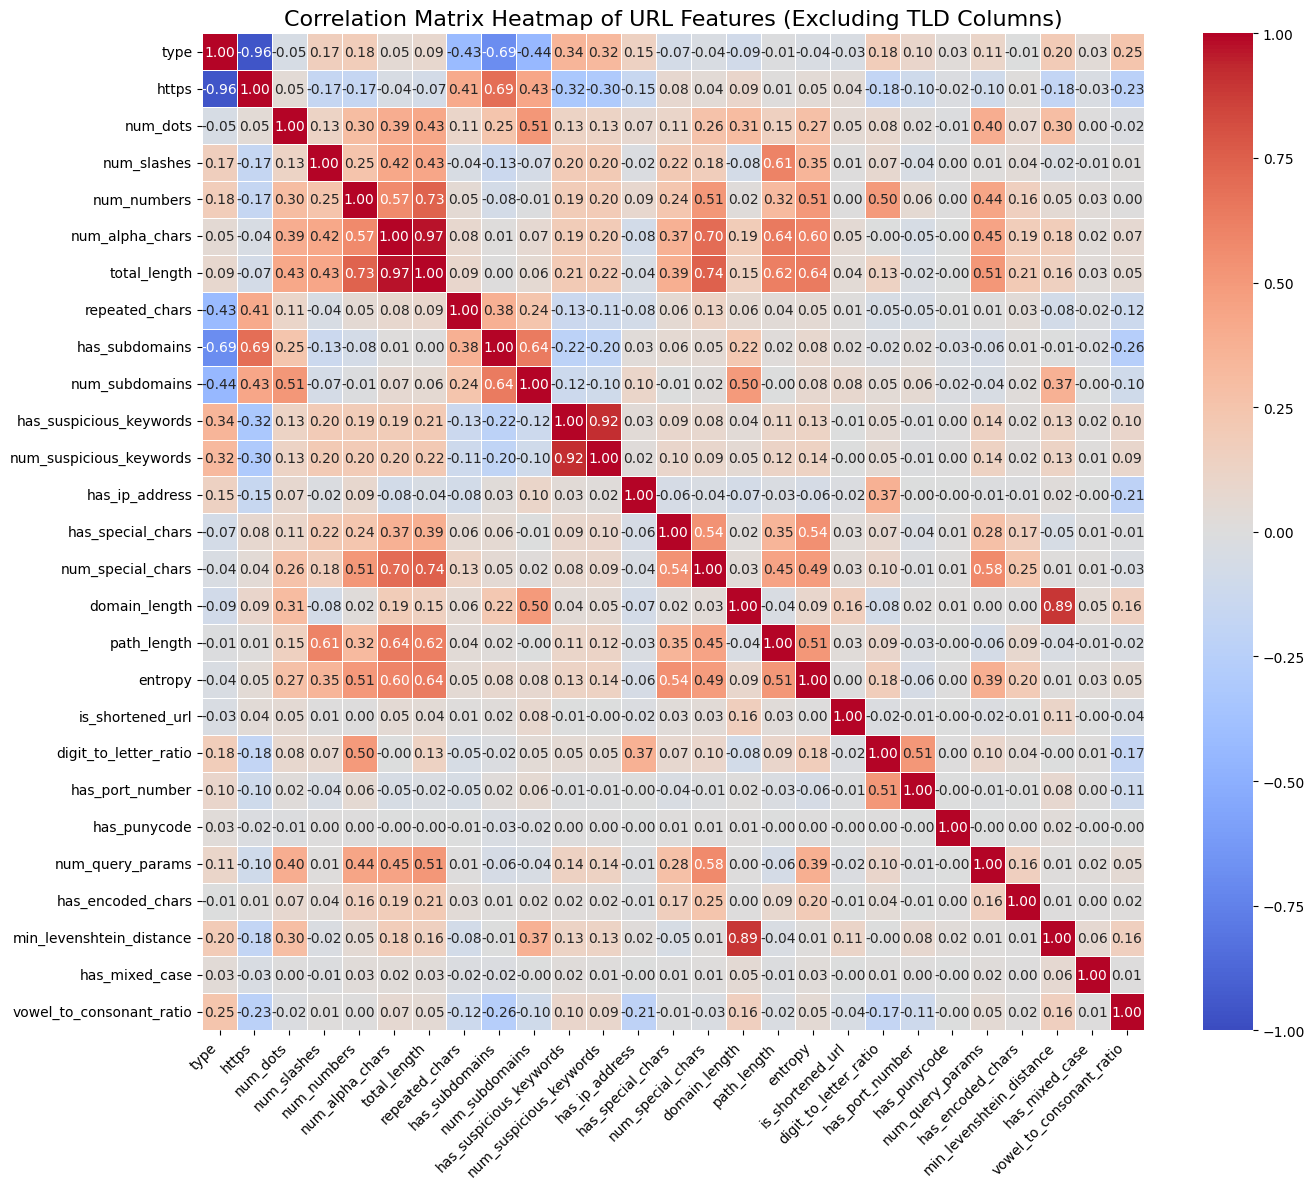

In [ ]:
# --- Create the Correlation Matrix and Heatmap ---
# Drop 'url' and any column containing 'tld'
df_extld = df.drop(columns=[col for col in df.columns if 'tld' in col or col == 'url'])

# Compute the correlation matrix
correlation_matrix = df_extld.corr()

# Set up the matplotlib figure
plt.figure(figsize=(14, 12))

# Create a heatmap with seaborn
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt='.2f', linewidths=0.5)

# Add title
plt.title('Correlation Matrix Heatmap of URL Features (Excluding TLD Columns)', fontsize=16)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Save the heatmap to a file
plt.savefig('correlation_heatmap.png')
print("\nCorrelation heatmap saved to 'correlation_heatmap.png'")

# Display the heatmap
plt.show()


We can see the veriables with multicorrlinity above. We will drop these to reduce bias in out model.

In [ ]:
# Drop multiple columns by specifying the list of column names
df = df.drop(columns=['num_suspicious_keywords', 'total_length'])

Running another to view the TDLs alone.


Correlation heatmap saved to 'correlation_heatmap_tld.png'


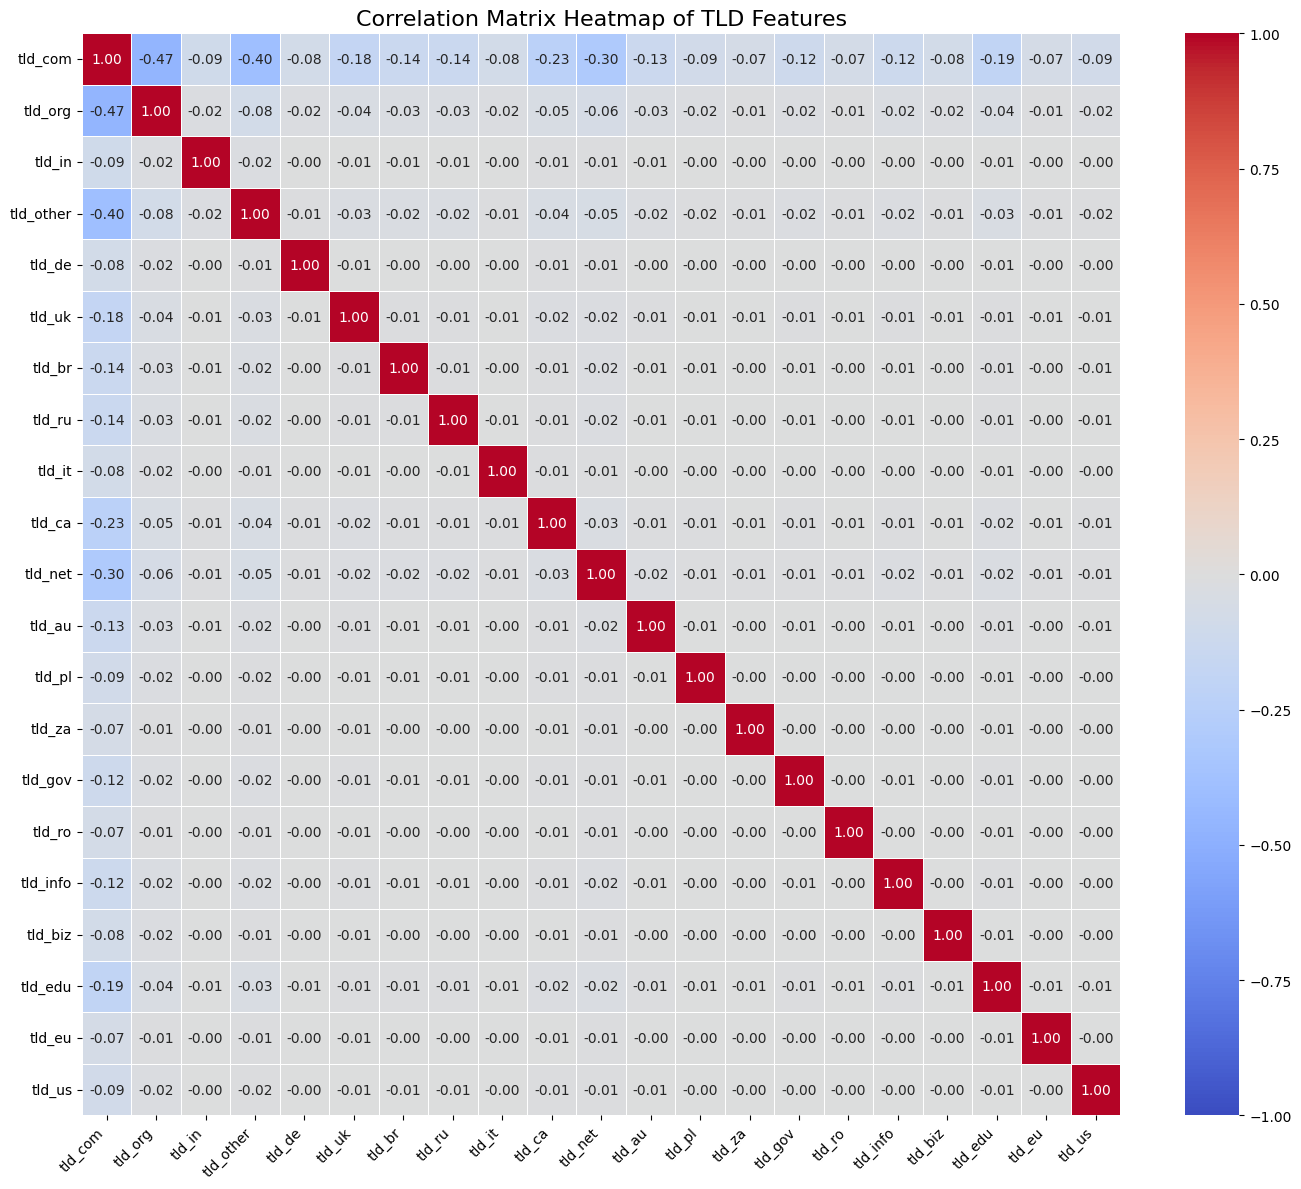

In [ ]:
# --- Create the Correlation Matrix and Heatmap for TLD Columns ---
# Select only columns that contain 'tld'
tld_df = df[[col for col in df.columns if 'tld' in col]]

# Compute the correlation matrix
correlation_matrix_tld = tld_df.corr()

# Set up the matplotlib figure
plt.figure(figsize=(14, 12))

# Create a heatmap with seaborn
sns.heatmap(correlation_matrix_tld, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt='.2f', linewidths=0.5)

# Add title
plt.title('Correlation Matrix Heatmap of TLD Features', fontsize=16)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Save the heatmap to a file
plt.savefig('correlation_heatmap_tld.png')
print("\nCorrelation heatmap saved to 'correlation_heatmap_tld.png'")

# Display the heatmap
plt.show()


In [ ]:
from scipy.stats import pearsonr

# Drop non-numeric columns ('url' and 'tld' columns)
df_cortype = df.drop(columns=['url'])

# Initialize lists to store results
correlations = []
p_values = []

# Iterate over each column and compute correlation and p-value with 'type'
for column in df_cortype.columns:
    if column != 'type':  # Skip the 'type' column itself
        corr, p_value = pearsonr(df_cortype['type'], df_cortype[column])
        correlations.append(corr)
        p_values.append(p_value)

# Create a DataFrame to display the results
correlation_results = pd.DataFrame({
    'Correlation': correlations,
    'P-Value': p_values
}, index=df_cortype.columns[df_cortype.columns != 'type'])

# Sort the DataFrame by the absolute value of the correlation in descending order
correlation_results_sorted = correlation_results.reindex(correlation_results['Correlation'].abs().sort_values(ascending=False).index)

# Show the sorted correlations and p-values
print(correlation_results_sorted)

/usr/local/lib/python3.11/dist-packages/scipy/stats/_stats_py.py:4894: RuntimeWarning: invalid value encountered in subtract
  ym = y - ymean


                          Correlation        P-Value
https                       -0.959505   0.000000e+00
has_subdomains              -0.691278   0.000000e+00
num_subdomains              -0.440716   0.000000e+00
repeated_chars              -0.426214   0.000000e+00
tld_other                    0.366529   0.000000e+00
has_suspicious_keywords      0.344723   0.000000e+00
tld_com                     -0.258134   0.000000e+00
vowel_to_consonant_ratio     0.247781   0.000000e+00
digit_to_letter_ratio        0.182668   0.000000e+00
num_numbers                  0.181180   0.000000e+00
num_slashes                  0.169440   0.000000e+00
tld_br                       0.159769   0.000000e+00
tld_ru                       0.154049   0.000000e+00
has_ip_address               0.145639   0.000000e+00
num_query_params             0.107646   0.000000e+00
tld_org                     -0.102072   0.000000e+00
tld_pl                       0.100862   0.000000e+00
has_port_number              0.099424   0.0000

Next we want to drop any veraibles that are not signifigant (p value over 0.00002). Or have a very weak relationship with 'type' (r under 0.001).

In [ ]:
# Drop multiple columns by specifying the list of column names
df = df.drop(columns=['min_levenshtein_distance', 'tld_uk', 'tld_us'])

In [ ]:
# Save the result to a CSV file for refreance
df.to_csv('final_parsed_urls_for_model.csv', index=False)

Now that we have our final dataset, we need to do a few more tweeks to prepare it for our model.

## 2. Data Preperation

As we already identified the variables of significance, we now want to ensure that our dataset is balanced so that it is not bias towards legitimate (0) or phishing (1) URLs.

Lets take a look at the distribution of our 'type'/target column/variable (legitimate/phishing).




In [9]:
# loading the final prepared dataset as a data frame if not already loaded
df = pd.read_csv('final_parsed_urls_for_model.csv')
df = pd.DataFrame(df)

<ipython-input-10-4176ab1022e9>:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['Legitimate', 'Phishing'])


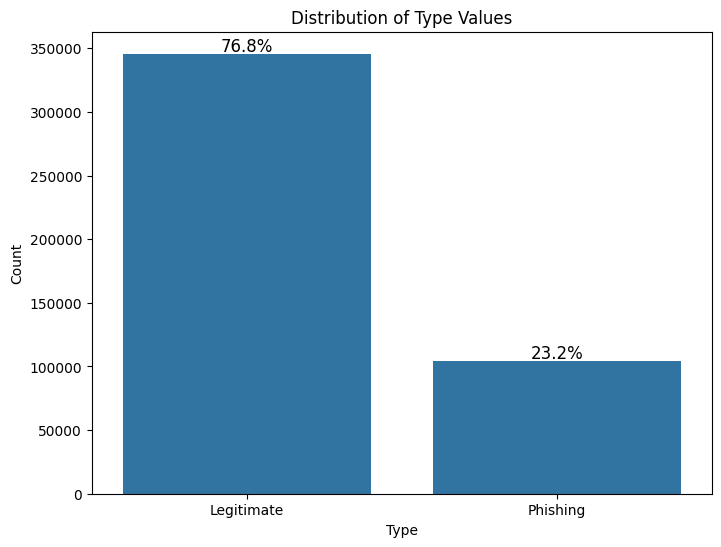

In [10]:
# Create a count plot for the 'type' column
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='type', data=df)

# Get the total number of rows in the dataset
total_count = len(df)

# Add percentage annotations on top of the bars
for p in ax.patches:
    height = p.get_height()
    percentage = (height / total_count) * 100
    ax.annotate(f'{percentage:.1f}%',
                (p.get_x() + p.get_width() / 2., height),
                ha='center', va='center',
                fontsize=12, color='black',
                xytext=(0, 5), textcoords='offset points')

# Set custom labels for the x-axis
ax.set_xticklabels(['Legitimate', 'Phishing'])

# Add title and labels
plt.title('Distribution of Type Values')
plt.xlabel('Type')
plt.ylabel('Count')

# Show the plot
plt.show()


In [11]:
from sklearn.utils import resample

# Separate the majority and minority classes
majority_class = df[df['type'] == 0]  # Majority class (0)
minority_class = df[df['type'] == 1]  # Minority class (1)

# Undersample the majority class
majority_class_undersampled = resample(
    majority_class,
    replace=False,  # Do not allow replacement (sampling without replacement)
    n_samples=len(minority_class),  # Match the number of samples in the minority class
    random_state=42  # For reproducibility
)

# Combine the undersampled majority class with the minority class
df_balanced = pd.concat([majority_class_undersampled, minority_class])

# Shuffle the dataset to mix the classes well
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Check the new class distribution
print(df_balanced['type'].value_counts())

type
1    104438
0    104438
Name: count, dtype: int64


<ipython-input-16-72595d4bb3e5>:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['Legitimate', 'Phishing'])


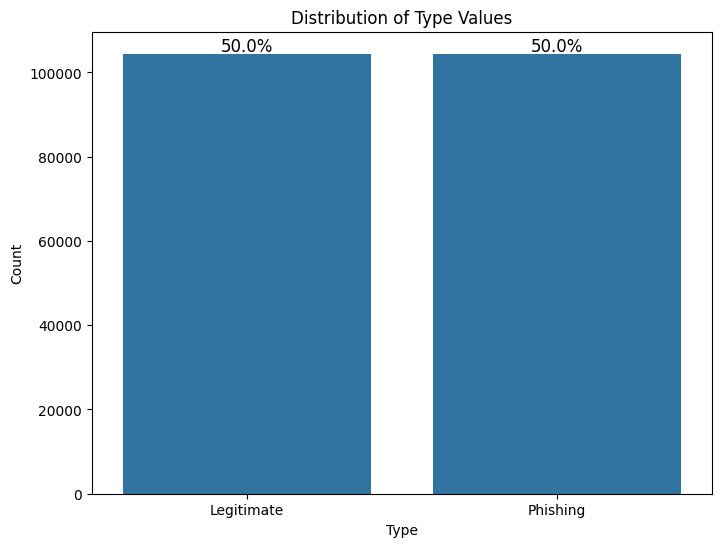

In [16]:
# Create a count plot for the 'type' column
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='type', data=df_balanced)

# Get the total number of rows in the dataset
total_count = len(df_balanced)

# Add percentage annotations on top of the bars
for p in ax.patches:
    height = p.get_height()
    percentage = (height / total_count) * 100
    ax.annotate(f'{percentage:.1f}%',
                (p.get_x() + p.get_width() / 2., height),
                ha='center', va='center',
                fontsize=12, color='black',
                xytext=(0, 5), textcoords='offset points')

# Set custom labels for the x-axis
ax.set_xticklabels(['Legitimate', 'Phishing'])

# Add title and labels
plt.title('Distribution of Type Values')
plt.xlabel('Type')
plt.ylabel('Count')

# Show the plot
plt.show()

In [15]:
# Drop non-numeric columns ('url' and 'tld' columns)
df_cortype_balanced = df_balanced.drop(columns=['url'])

# Initialize lists to store results
correlations_balanced = []
p_values_balanced = []

# Iterate over each column and compute correlation and p-value with 'type'
for column in df_cortype_balanced.columns:
    if column != 'type':  # Skip the 'type' column itself
        corr, p_value = pearsonr(df_cortype_balanced['type'], df_cortype_balanced[column])
        correlations_balanced.append(corr)
        p_values_balanced.append(p_value)

# Create a DataFrame to display the results
correlation_results = pd.DataFrame({
    'Correlation': correlations_balanced,
    'P-Value': p_values_balanced
}, index=df_cortype_balanced.columns[df_cortype_balanced.columns != 'type'])

# Sort the DataFrame by the absolute value of the correlation in descending order
correlation_results_sorted = correlation_results.reindex(correlation_results['Correlation'].abs().sort_values(ascending=False).index)

# Show the sorted correlations and p-values
print(correlation_results_sorted)

                          Correlation        P-Value
https                       -0.939737   0.000000e+00
has_subdomains              -0.612558   0.000000e+00
num_subdomains              -0.453169   0.000000e+00
repeated_chars              -0.364786   0.000000e+00
tld_other                    0.324819   0.000000e+00
tld_com                     -0.289322   0.000000e+00
has_suspicious_keywords      0.288604   0.000000e+00
vowel_to_consonant_ratio     0.249487   0.000000e+00
num_slashes                  0.177712   0.000000e+00
digit_to_letter_ratio        0.159950   0.000000e+00
num_numbers                  0.159108   0.000000e+00
tld_org                     -0.136044   0.000000e+00
tld_br                       0.130611   0.000000e+00
tld_ru                       0.127519   0.000000e+00
has_ip_address               0.117949   0.000000e+00
num_query_params             0.104167   0.000000e+00
tld_edu                     -0.098197   0.000000e+00
domain_length               -0.094132   0.0000

In [ ]:
# Save the blanced dataset to CSV for refreance
df.to_csv('final_balanced_parsed_urls_for_model.csv', index=False)

In [ ]:
# loading the balanced dataset as a data frame if not already loaded
df_balanced = pd.read_csv('final_balanced_parsed_urls_for_model.csv')
df_balanced = pd.DataFrame(df_balanced)

In [ ]:
df_balanced.head(5)

,url,type,https,num_dots,num_slashes,num_numbers,num_alpha_chars,repeated_chars,has_subdomains,num_subdomains,...,tld_net,tld_au,tld_pl,tld_za,tld_gov,tld_ro,tld_info,tld_biz,tld_edu,tld_eu
0,https://www.google.com,0,1,2,2,0,17,3,1,1,...,0,0,0,0,0,0,0,0,0,0
1,https://www.youtube.com,0,1,2,2,0,18,3,1,1,...,0,0,0,0,0,0,0,0,0,0
2,https://www.facebook.com,0,1,2,2,0,19,3,1,1,...,0,0,0,0,0,0,0,0,0,0
3,https://www.baidu.com,0,1,2,2,0,16,3,1,1,...,0,0,0,0,0,0,0,0,0,0
4,https://www.wikipedia.org,0,1,2,2,0,20,3,1,1,...,0,0,0,0,0,0,0,0,0,0


## 3. Model Building/Testing

3A. Logistic Regression - Chosen for it's interpretability and suspected linear decision boundary.

In [ ]:
# loading the balanced dataset as a data frame if not already loaded
df_balanced = pd.read_csv('final_balanced_parsed_urls_for_model.csv')
df_balanced = pd.DataFrame(df_balanced)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Preprocess the data
X = df_balanced.drop(columns=['type', 'url'])  # Drop 'type' and 'url' columns
y = df_balanced['type']  # 'type' is the target variable

# Scale numeric features
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

# Train the Logistic Regression model
log_reg = LogisticRegression(solver='liblinear', class_weight='balanced')  # Class weight helps with imbalanced data
log_reg.fit(X_train, y_train)

# Make predictions on the test set
y_pred = log_reg.predict(X_test)

# Evaluate the model and view metrics
print("Accuracy Score:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("AUC-ROC Score:", roc_auc_score(y_test, log_reg.predict_proba(X_test)[:, 1]))

# Compute performance metrics for Logistic Regression
log_reg_metrics = {
    'Accuracy': accuracy_score(y_test, log_reg.predict(X_test)),
    'Precision': precision_score(y_test, log_reg.predict(X_test)),
    'Recall': recall_score(y_test, log_reg.predict(X_test)),
    'F1-Score': f1_score(y_test, log_reg.predict(X_test)),
    'AUC-ROC': roc_auc_score(y_test, log_reg.predict_proba(X_test)[:, 1])
}

Accuracy Score: 0.9922364387578302

Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99     69148
           1       0.99      0.98      0.98     20888

    accuracy                           0.99     90036
   macro avg       0.99      0.99      0.99     90036
weighted avg       0.99      0.99      0.99     90036

AUC-ROC Score: 0.997898085447503


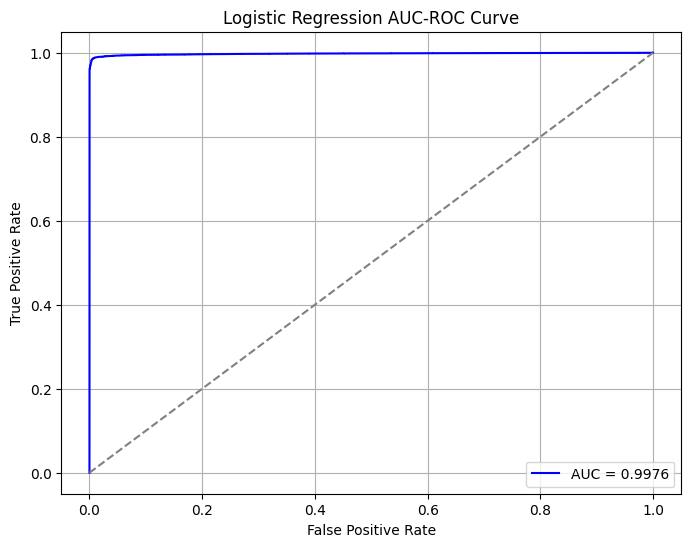

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score

# Get the predicted probabilities for the positive class (1)
y_prob = log_reg.predict_proba(X_test)[:, 1]

# Compute the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# Compute the AUC score
auc_score = roc_auc_score(y_test, y_prob)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'AUC = {auc_score:.4f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line (random classifier)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression AUC-ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)

# Show the plot
plt.show()

3B. 5-Fold Cross Validation Logistic Regression

In [ ]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score

# Preprocess the data
X = df_balanced.drop(columns=['type', 'url'])  # Drop 'type' and 'url' columns
y = df_balanced['type']  # 'type' is the target variable

# Scale numeric features
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# Create a StratifiedKFold for cross-validation to preserve the class distribution
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize Logistic Regression model with class weights for imbalanced data
log_reg = LogisticRegression(solver='liblinear', class_weight='balanced')

# Perform cross-validation for Logistic Regression
log_reg_cv_accuracy = cross_val_score(log_reg, X_scaled, y, cv=cv, scoring='accuracy')
log_reg_cv_precision = cross_val_score(log_reg, X_scaled, y, cv=cv, scoring='precision')
log_reg_cv_recall = cross_val_score(log_reg, X_scaled, y, cv=cv, scoring='recall')
log_reg_cv_f1 = cross_val_score(log_reg, X_scaled, y, cv=cv, scoring='f1')
log_reg_cv_auc = cross_val_score(log_reg, X_scaled, y, cv=cv, scoring='roc_auc')

In [ ]:
# Print out the results from cross-validation
print(f"Cross-validated Accuracy Scores: {log_reg_cv_accuracy}")
print(f"Mean Cross-validated Accuracy: {log_reg_cv_accuracy.mean():.4f}")
print(f"Cross-validated AUC-ROC Scores: {log_reg_cv_auc}")
print(f"Mean Cross-validated AUC-ROC: {log_reg_cv_auc.mean():.4f}")

# Compute mean performance metrics
log_reg_cv_metrics = {
    'Accuracy': np.mean(log_reg_cv_accuracy),
    'Precision': np.mean(log_reg_cv_precision),
    'Recall': np.mean(log_reg_cv_recall),
    'F1-Score': np.mean(log_reg_cv_f1),
    'AUC-ROC': np.mean(log_reg_cv_auc)
}

Cross-validated Accuracy Scores: [0.99293616 0.99103682 0.99219193 0.99260288 0.99185872]
Mean Cross-validated Accuracy: 0.9921
Cross-validated AUC-ROC Scores: [0.99788459 0.99714592 0.99789377 0.99774886 0.99771896]
Mean Cross-validated AUC-ROC: 0.9977


In [ ]:
# Train the CV log model and evaluate it on the entire dataset
log_reg.fit(X_scaled, y)

# Make predictions
y_pred = log_reg.predict(X_scaled)

# Evaluate the model
print("\nFinal Model Evaluation:")
print("Accuracy Score:", accuracy_score(y, y_pred))
print("\nClassification Report:\n", classification_report(y, y_pred))
print("AUC-ROC Score:", roc_auc_score(y, log_reg.predict_proba(X_scaled)[:, 1]))

In [ ]:
# Get feature importance (coefficients)
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': log_reg.coef_[0]
})

# Sort by absolute value of coefficients (strongest predictors first)
feature_importance['Abs_Coefficient'] = feature_importance['Coefficient'].abs()
feature_importance = feature_importance.sort_values(by='Abs_Coefficient', ascending=False)

# Display the top features
print("Most Significant Features:")
print(feature_importance[['Feature', 'Coefficient']].head(10))  # Adjust to see more features

Most Significant Features:
                     Feature  Coefficient
0                      https   -13.917749
6             has_subdomains    -1.860609
22  vowel_to_consonant_ratio     1.825192
7             num_subdomains    -1.728068
4            num_alpha_chars     1.422095
8    has_suspicious_keywords     1.265462
5             repeated_chars    -1.125705
13               path_length    -0.957758
3                num_numbers     0.909471
16     digit_to_letter_ratio     0.877324


3C. XGBoost - Chosen for their known performerence for a wide range of binary classification problems.

In [ ]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score

# Preprocess the data
X = df.drop(columns=['type', 'url'])  # Drop 'type' and 'url' columns
y = df['type']  # 'type' is the target variable

# Scale numeric features
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

# Train XGBoost classifier
xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',  # Binary classification
    eval_metric='logloss',
    use_label_encoder=False,
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

xgb_model.fit(X_train, y_train)

# Make predictions
y_pred = xgb_model.predict(X_test)
y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]  # Probabilities for AUC-ROC

# Evaluate the model
print("XGBoost Accuracy Score:", accuracy_score(y_test, y_pred))
print("\nXGBoost Classification Report:\n", classification_report(y_test, y_pred))
print("XGBoost AUC-ROC Score:", roc_auc_score(y_test, y_pred_proba))

xgb_metrics = {
    'Accuracy': accuracy_score(y_test, xgb_model.predict(X_test)),
    'Precision': precision_score(y_test, xgb_model.predict(X_test)),
    'Recall': recall_score(y_test, xgb_model.predict(X_test)),
    'F1-Score': f1_score(y_test, xgb_model.predict(X_test)),
    'AUC-ROC': roc_auc_score(y_test, xgb_model.predict_proba(X_test)[:, 1])
}

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:11:33] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Accuracy Score: 0.9972455462259541

XGBoost Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     69148
           1       1.00      0.99      0.99     20888

    accuracy                           1.00     90036
   macro avg       1.00      0.99      1.00     90036
weighted avg       1.00      1.00      1.00     90036

XGBoost AUC-ROC Score: 0.9992613140278468


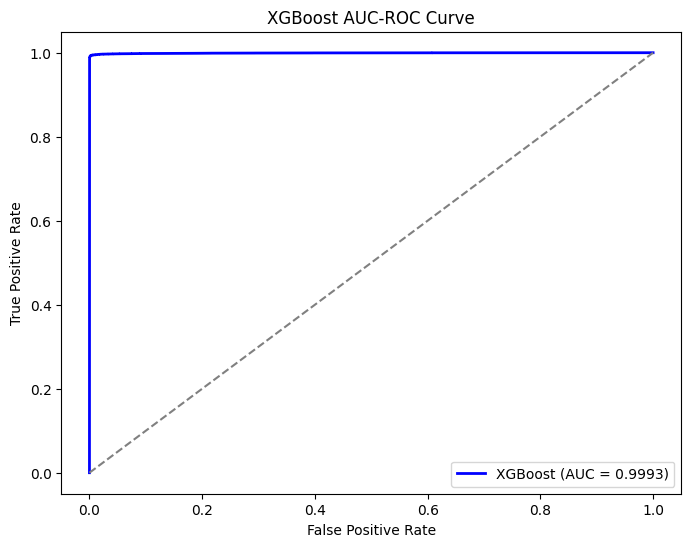

In [ ]:
from sklearn.metrics import roc_curve, auc

# Get false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Compute AUC score
roc_auc = auc(fpr, tpr)

# Plot the AUC-ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'XGBoost (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Random chance line

# Labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('XGBoost AUC-ROC Curve')
plt.legend(loc='lower right')

# Show plot
plt.show()

After training each model, we took a look at what features impacted the XGBoost model’s decision the most. As this is the model that we will be moving forward with based on it’s performance. We analyzed feature importance two different ways. Frequence-Based and Gain-based importance.

Weight-Based performance (frequency) calculates the number of times a feature is used in a tree split (within the XGBoost model). A higher weight means the feature has been used more often during the model’s training and is generally considered more important for making predictions. Figure 5 shows that the ‘vowel_to_consonant_ratio’ provided a significant improvement to the model’s prediction accuracy, as it was used most often for tree decisions.


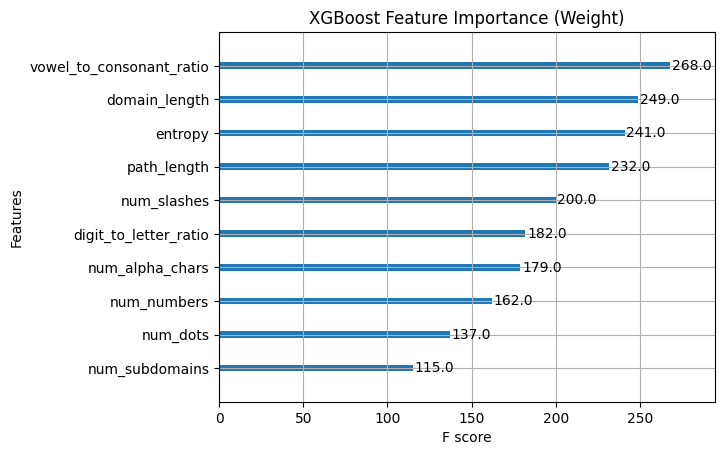

In [ ]:
# Plot feature importance (Weight or "Frequency")
xgb.plot_importance(xgb_model, max_num_features=10, importance_type="weight")  # Show top 10 features
plt.title("XGBoost Feature Importance (Weight)")
plt.show()

Gain-Based performance calculates the average improvement in accuracy (reduction in loss function) brought by a feature when it is used in the model. A feature with a high gain provides a significant improvement to the model’s prediction accuracy.

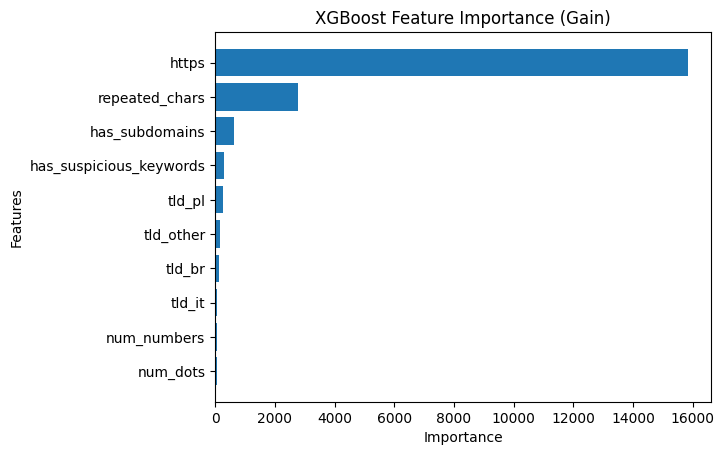

In [ ]:
import matplotlib.pyplot as plt
import xgboost as xgb
import numpy as np

# Get feature importance values
importance = xgb_model.get_booster().get_score(importance_type="gain")

# Sort and select the top 10 features in descending order
sorted_importance = sorted(importance.items(), key=lambda x: x[1], reverse=True)[:10]
features, scores = zip(*sorted_importance)

# Round the importance scores to integers
scores = [int(score) for score in scores]

# Plot the feature importance with largest on top
plt.barh(features[::-1], scores[::-1])  # Reverse the order of features and scores
plt.title("XGBoost Feature Importance (Gain)")
plt.xlabel('Importance')
plt.ylabel('Features')

plt.show()

## 4. Compare Model Preformance

In [ ]:
# Create a DataFrame to compare both models
comparison_df = pd.DataFrame([log_reg_metrics, log_reg_cv_metrics, xgb_metrics], index=['Logistic Regression', '5CV Logistic Regression', 'XGBoost'])

# Display the comparison table
print(comparison_df)

                         Accuracy  Precision    Recall  F1-Score   AUC-ROC
Logistic Regression      0.988031   0.996638  0.979366  0.987927  0.997634
5CV Logistic Regression  0.986241   0.995647  0.976752  0.986108  0.997508
XGBoost                  0.995356   0.998651  0.992053  0.995341  0.999281


<Figure size 1000x600 with 0 Axes>

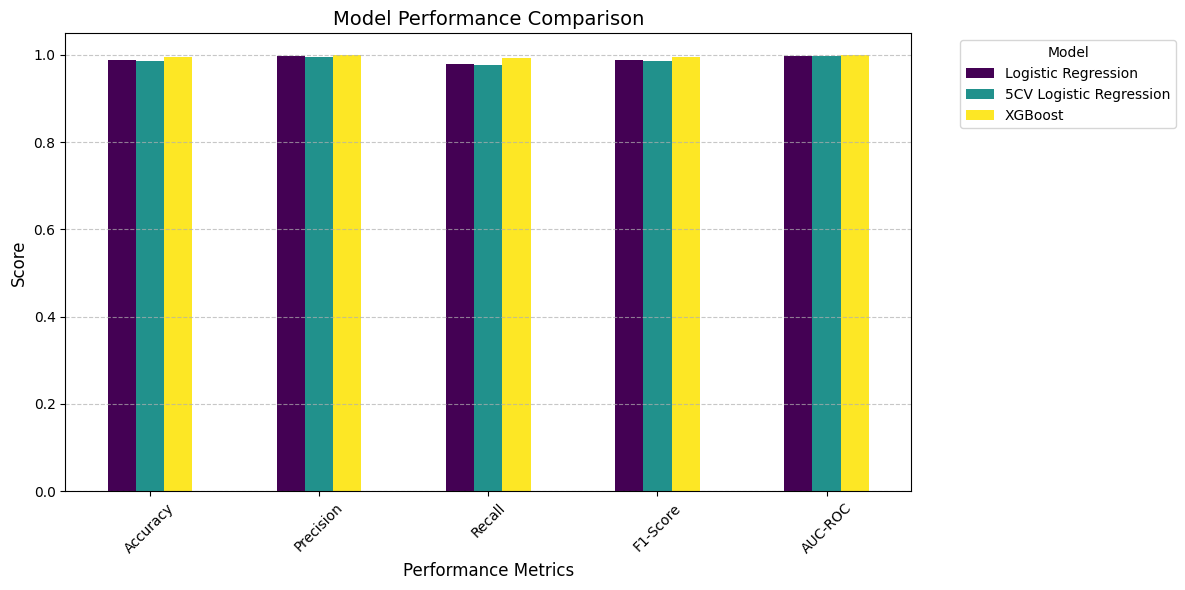

In [ ]:
# Transpose the dataframe for better plotting
comparison_df_t = comparison_df.T

# Set the figure size
plt.figure(figsize=(10, 6))

# Plot the comparison using a bar chart
comparison_df_t.plot(kind='bar', figsize=(12, 6), colormap='viridis')

# Add labels and title
plt.title('Model Performance Comparison', fontsize=14)
plt.xlabel('Performance Metrics', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title="Model", bbox_to_anchor=(1.05, 1), loc='upper left')

# Show grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Display the plot
plt.tight_layout()
plt.show()

## 5. Model Application (XGBoost)

In [ ]:
# Bad Link
df_test = pd.DataFrame({'url': ["app.us4z00m.us//8697479733?7pwd=C8KipulinCGxBZ87e4Gh.51RZENGthLZ"]})

In [ ]:
# Pull chosen Features from static URL (bad link) ---
# Re-define functions from step 1 if needed first
df_test['https'] = df_test['url'].apply(has_https)
df_test['tld'] = df_test['url'].apply(get_tld)
df_test['num_dots'] = df_test['url'].apply(count_dots)
df_test['num_slashes'] = df_test['url'].apply(count_slashes)
df_test['num_numbers'] = df_test['url'].apply(count_numbers)
df_test['num_alpha_chars'] = df_test['url'].apply(count_alpha_chars)
df_test['repeated_chars'] = df_test['url'].apply(longest_repeated_sequence)
df_test['has_subdomains'] = df_test['url'].apply(has_subdomains)
df_test['num_subdomains'] = df_test['url'].apply(count_subdomains)
df_test['has_suspicious_keywords'] = df_test['url'].apply(has_suspicious_keywords)
df_test['has_ip_address'] = df_test['url'].apply(has_ip_address)
df_test['has_special_chars'] = df_test['url'].apply(has_special_chars)
df_test['num_special_chars'] = df_test['url'].apply(count_special_chars)
df_test['domain_length'] = df_test['url'].apply(domain_length)
df_test['path_length'] = df_test['url'].apply(path_length)
df_test['entropy'] = df_test['url'].apply(calculate_entropy)
df_test['is_shortened_url'] = df_test['url'].apply(is_shortened_url)
df_test['digit_to_letter_ratio'] = df_test['url'].apply(digit_to_letter_ratio)
df_test['has_port_number'] = df_test['url'].apply(has_port_number)
df_test['has_punycode'] = df_test['url'].apply(has_punycode)
df_test['num_query_params'] = df_test['url'].apply(count_query_params)
df_test['has_encoded_chars'] = df_test['url'].apply(has_encoded_chars)
df_test['has_mixed_case'] = df_test['url'].apply(has_mixed_case)
df_test['vowel_to_consonant_ratio'] = df_test['url'].apply(vowel_to_consonant_ratio)

In [ ]:
# Identify boolean columns (excluding 'url')
bool_columns = [col for col in df_test.columns if df_test[col].dtype == 'bool' and col != 'url']

# Convert boolean columns to numeric (True -> 1, False -> 0)
for col in bool_columns:
    df_test[col] = df_test[col].astype(int)

# Convert only float columns
df_test[['entropy', 'digit_to_letter_ratio', 'vowel_to_consonant_ratio']] = df_test[['entropy', 'digit_to_letter_ratio', 'vowel_to_consonant_ratio']].apply(pd.to_numeric, errors='coerce')

In [ ]:
# Get the feature columns from the training set
expected_columns = X_scaled.columns  # These are the features used in training

# Ensure the test dataframe has the same columns, filling missing ones with 0
df_test = df_test.reindex(columns=expected_columns, fill_value=0)

In [ ]:
# Scale the features using the same StandardScaler
url_scaled = pd.DataFrame(scaler.transform(df_test), columns=df_test.columns)

In [ ]:
# view pasred link
df_test

,https,num_dots,num_slashes,num_numbers,num_alpha_chars,repeated_chars,has_subdomains,num_subdomains,has_suspicious_keywords,has_ip_address,...,tld_net,tld_au,tld_pl,tld_za,tld_gov,tld_ro,tld_info,tld_biz,tld_edu,tld_eu
0,0,3,2,20,37,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Make a prediction for the test URL
y_test_pred = xgb_model.predict(df_test)
y_test_proba = xgb_model.predict_proba(df_test)[:, 1]  # Probability of phishing

# Output results
predicted_label = "Phishing" if y_test_pred[0] == 1 else "Legitimate"
print(f"Predicted Type: {predicted_label}")
print(f"Phishing Probability: {y_test_proba[0]:.4f}")

Predicted Type: Phishing
Phishing Probability: 1.0000


## 6. Looking deeper at feature importance

In [ ]:
# loading the balanced dataset as a data frame if not already loaded
df_balanced = pd.read_csv('final_balanced_parsed_urls_for_model.csv')
df_balanced = pd.DataFrame(df_balanced)

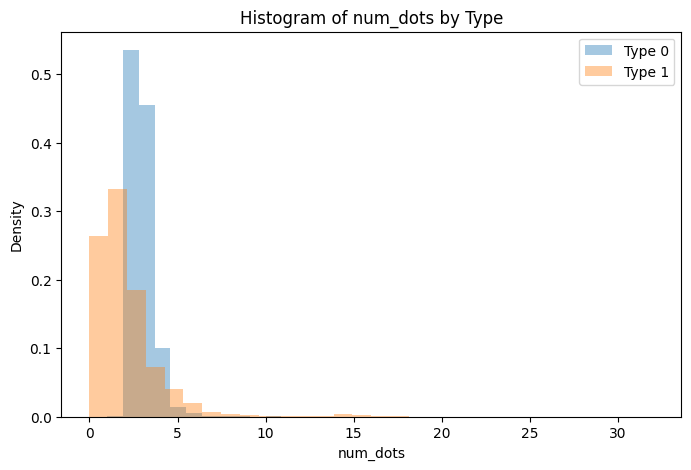

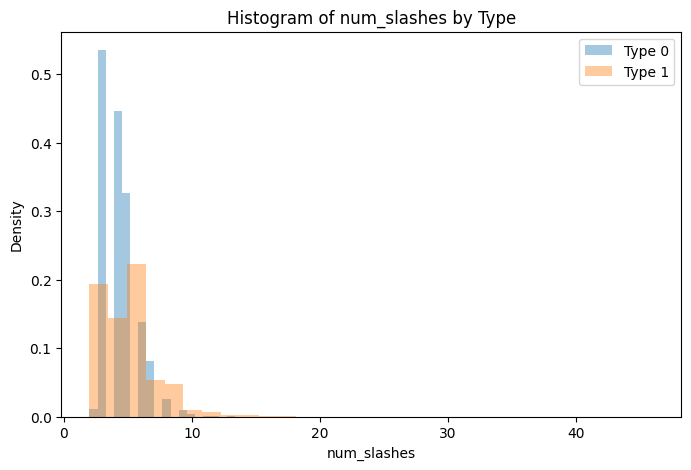

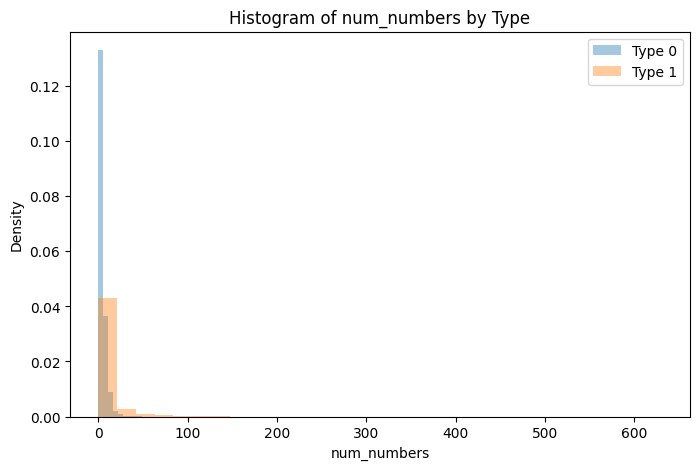

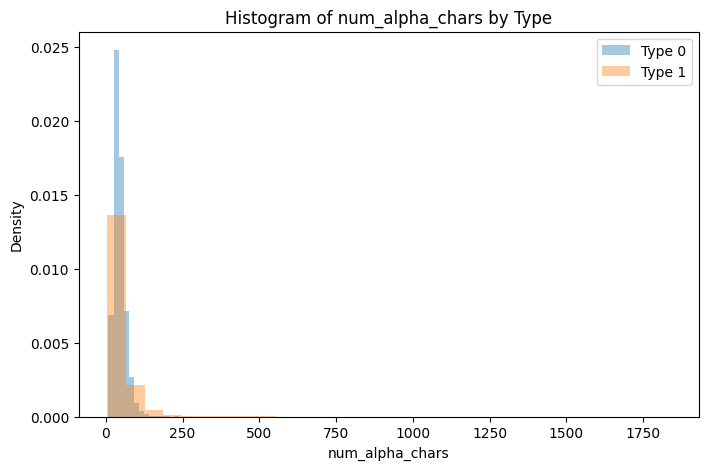

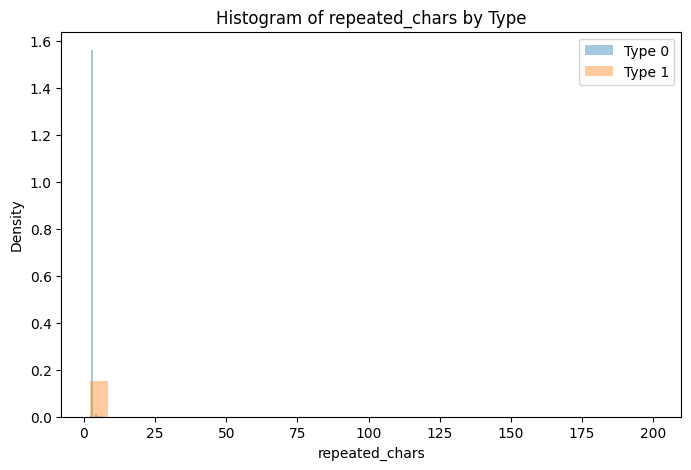

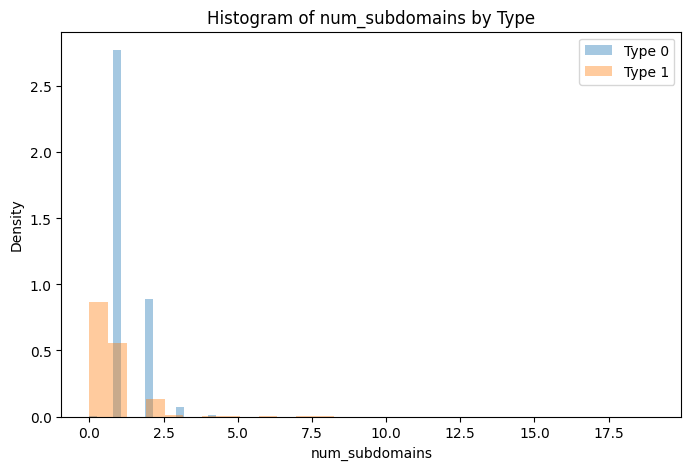

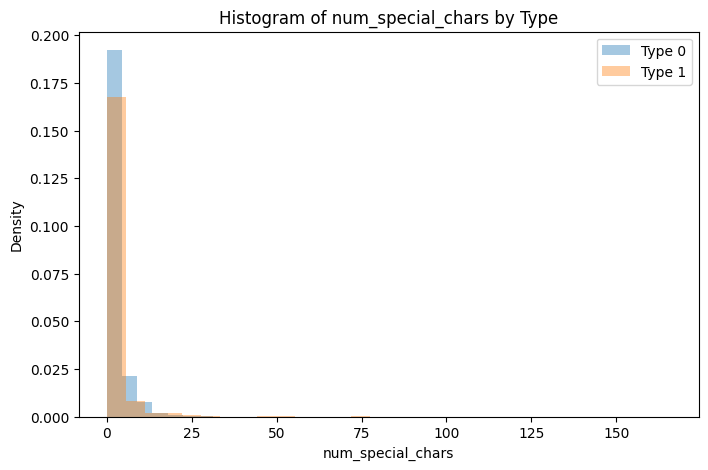

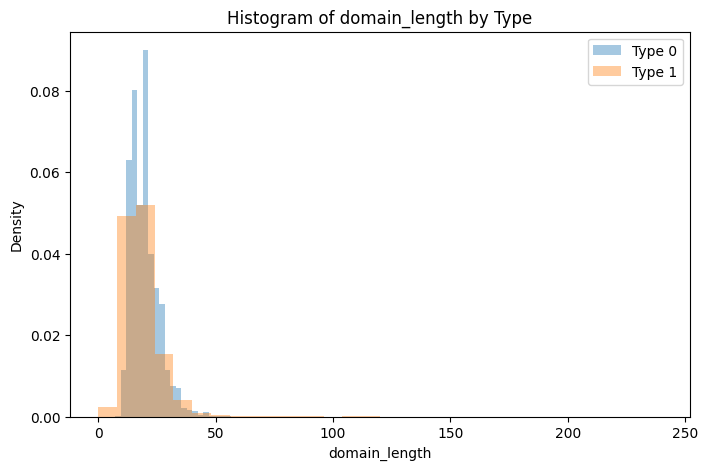

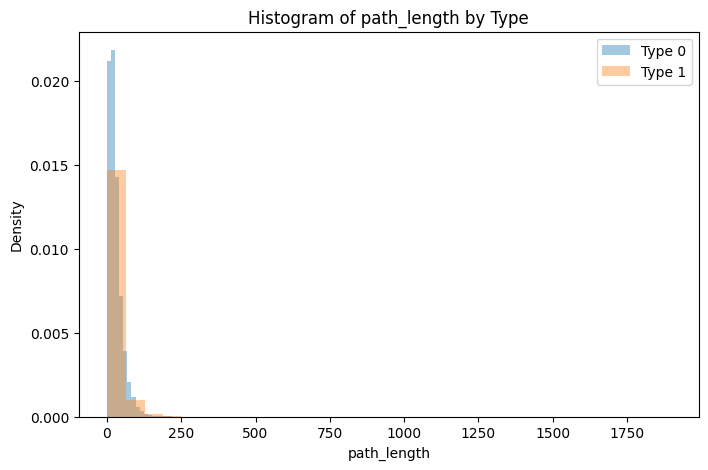

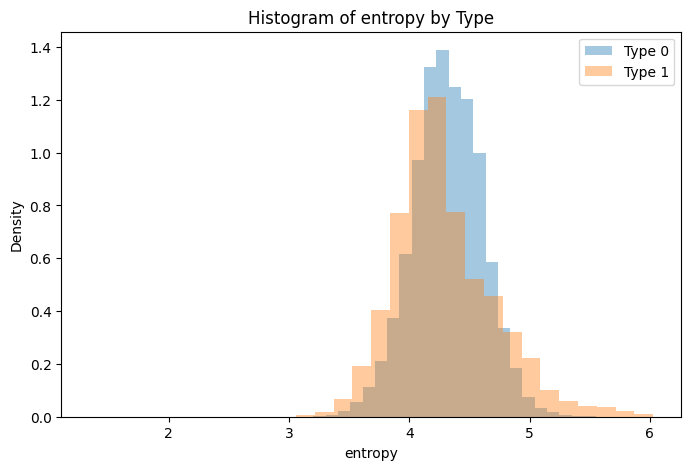

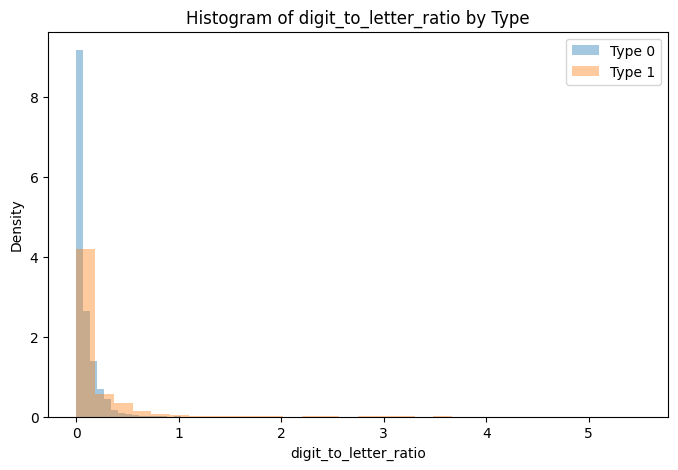

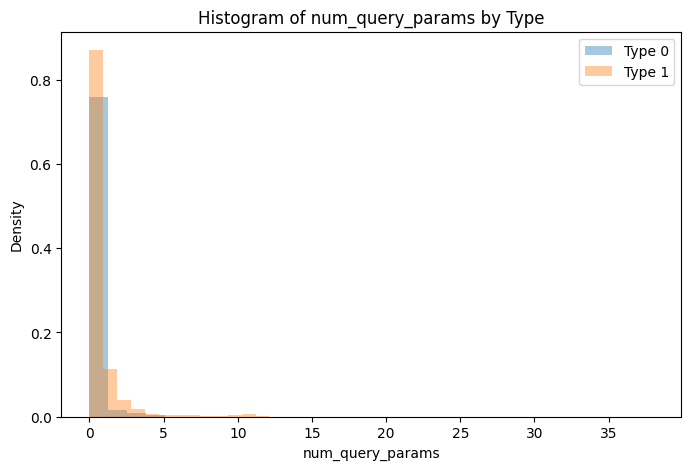

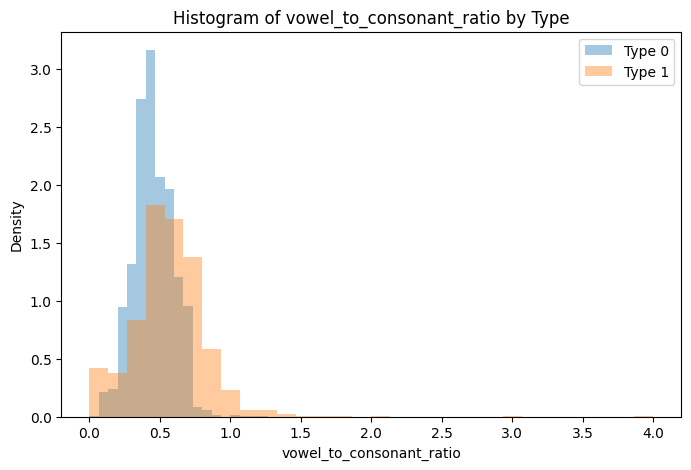

In [ ]:
# Function to check if a column contains only binary values
def is_binary(col):
    return set(col.dropna()) == {0, 1}

# Filter out binary columns from numeric_columns
numeric_columns_filtered = [col for col in numeric_columns if not is_binary(df_balanced[col])]

for col in numeric_columns_filtered:
    plt.figure(figsize=(8, 5))
    for t in type_values:
        subset = df_balanced[df_balanced['type'] == t]
        plt.hist(subset[col], bins=30, alpha=0.4, label=f'Type {t}', density=True)
    plt.title(f'Histogram of {col} by Type')
    plt.xlabel(col)
    plt.ylabel('Density')
    plt.legend()
    plt.show()


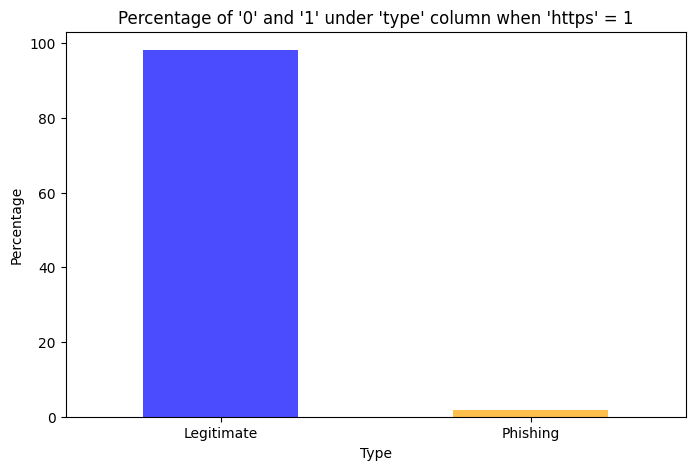

In [ ]:
# Filter rows where 'https' column equals "1"
df_https_1 = df_balanced[df_balanced['https'] == 1]

# Group by 'type' and calculate the count of each unique value (0 or 1)
type_counts = df_https_1['type'].value_counts(normalize=True) * 100

# Plot the results
plt.figure(figsize=(8, 5))
type_counts.plot(kind='bar', color=['blue', 'orange'], alpha=0.7)
plt.title("Percentage of '0' and '1' under 'type' column when 'https' = 1")
plt.xlabel("Type")
plt.ylabel("Percentage")
plt.xticks(ticks=[0, 1], labels=["Legitimate", "Phishing"], rotation=0)
plt.show()